In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import os

import pandas as pd
import numpy as np


from funcs.helper import read_custom_aperture_lc, fetch_lightcurve
from funcs.multiperiod import show_flare, find_period


from scipy import optimize

In [23]:
CWD = "/".join(os.getcwd().split("/")[:-2])
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.370150,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,NaN,NaN,0.193000,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.351250,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.113000,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.190000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.132000,NaN,Zhan+19,UCAC4 116-015389,NaN
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,9.854,NaN,13.5570,10.8,0.7,0.378325,0.6844128,Kesseli+2018,NaN,NaN


In [24]:
row = lcs.loc[4]
row

ID                             277539431
QCS                                   12
typ                                  slc
cadence_min                            2
mission                             tess
prefix                               TIC
origin                            custom
h_mission                           TESS
SpT                                   M7
view_start                          1641
view_stop                         1643.5
view_min                             750
view_max                             970
BJDoff                           2457000
tstart                           1641.84
ampl_min                             0.9
ampl_max                             1.7
GRP                                 1.52
plxmas                           72.9672
eplxmas                            0.569
RA                               163.815
Dec                             -73.9364
J                                  10.63
R                                    NaN
Gaia_G          

In [39]:
def remove_sinusoidal2(target, plot=False, save=False, plotmini=False):
    """Fit a sinusoidal modulation and
    subtract it from the flux.

    Parameters:
    -----------
    target : Series
        Description of the target.
    plot : bool
        If True, will plot the periodogram
    save : bool
        If True, will save periodogram plot to file.

    Return:
    -------
    time, subtracted flux, model, period:
    array, array, array, astropy.Quantity
    """
    def cosine(x, a, b, c, d, e):
        """cosine with a linear trend"""
        return a * np.cos(b * x + c) + d * x + e

    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux)],
                                  method="lm")
    model = cosine(flck.time, p[0], p[1], p[2], p[3], p[4])

    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

    if plotmini==True:
        plt.figure(figsize=(3,2))

        # Plot the original LC
        plt.plot(flck.time, flck.flux,c="grey",linewidth=2,
                 label=(f"{target.prefix} {target.ID},"\
                        f" S{target.QCS}, {target.SpT}V"))

        offset = (target.view_max - target.view_min) * .3
        subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model

        #Layout
        plt.xlim(target.view_start,target.view_stop)
        plt.ylim(target.view_min,1200)
        plt.xlabel(f"time [BJD-{int(target.BJDoff)}]",fontsize=14)
        plt.ylabel("flux [e$^{-}]$",fontsize=14)

        # Save optionally
        plt.tight_layout()
        if save==True:
            plt.savefig(f"{CWD}/analysis/plots/{target.ID}_s{target.QCS}_sinusoidal_paperversionmini.png",dpi=300)

    
    # Plot the subtracted light curve
    if plot==True:

        plt.figure(figsize=(8,6))

        # Plot the original LC
        plt.plot(flck.time, flck.flux,c="grey",linewidth=2,
                 label=(f"{target.prefix} {target.ID},"\
                        f" S{target.QCS}, {target.SpT}V"))

        # Overplot the fitted function
        plt.plot(flck.time, model,linewidth=2,
                 c="navy",label=f"{period:.2f} rotation period")

        # Plot the flux with the model subtracted
        offset = (target.view_max - target.view_min) * .3 *3
        subtracted_flux = np.nanmedian(flck.flux) + flck.flux - model
        plt.plot(flck.time, offset + subtracted_flux,
                 c="r",label="periodic signal subtracted", linewidth=2)

        # Overplot the median flux value on the subtracted LC
        plt.plot(flck.time, offset + np.full(len(flck.time), np.nanmedian(flck.flux)),
                 c="k", label="median (offset)", linewidth=2)

        #Layout
        plt.xlim(target.view_start,target.view_stop)
        plt.ylim(target.view_min,1350)#target.view_max+offset)
       # plt.ylim(380,570)
        plt.xlabel(f"time [BJD-{int(target.BJDoff)}]",fontsize=14)
        plt.ylabel("flux [e$^{-}]$",fontsize=14)
        plt.legend()
        plt.tight_layout()
        # Save optionally
        if save==True:
            plt.savefig(f"{CWD}/analysis/plots/{target.ID}_s{target.QCS}_sinusoidal_paperversion.png",dpi=300)

    return flck.time, subtracted_flux, model, period

In [40]:
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

## Fit a sinusoidal modulation and plot the residual

TIC 277539431 modulation period:  4.556764823311947 h
Relative amplitude of modulation: 5.4e-03


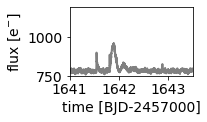

In [41]:
t, s_flux, model, period = remove_sinusoidal2(row, plotmini=True, save=True)

TIC 277539431 modulation period:  4.556764823311947 h
Relative amplitude of modulation: 5.4e-03


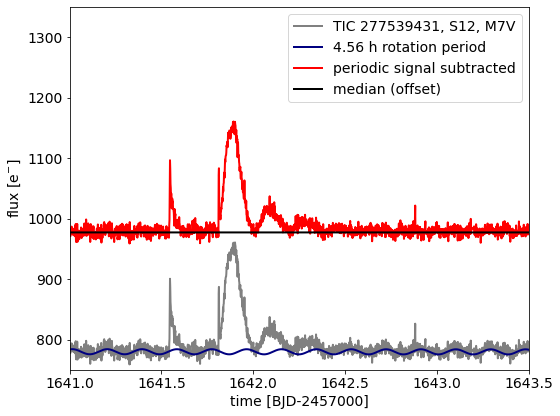

In [42]:
t, s_flux, model, period = remove_sinusoidal2(row, plot=True, save=True)